In [1]:
import numpy as np
import cupy as cp
from holotomocupy.holo import G, GT
from holotomocupy.shift import S, ST
from holotomocupy.chunking import gpu_batch
from holotomocupy.recon_methods import CTFPurePhase, multiPaganin
from holotomocupy.proc import dai_yuan, linear
import holotomocupy.chunking as chunking
from holotomocupy.utils import *



astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 512  # object size in each dimension

noise = 0
z1c = -19.5e-3
# thickness of the coded aperture
code_thickness = 1.8e-6 #in m
# feature size
ill_feature_size = 2e-6 #in m

# ntheta = int(sys.argv[1])  # number of angles (rotations)
# noise = int(sys.argv[2])#sys.argv[2]=='True'
# z1c = float(sys.argv[3])  # positions of the code and the probe for reconstruction

center = n/2 # rotation axis
npos = 49  # number of code positions
detector_pixelsize = 3e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = z1c
z1 = np.tile(z1, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnifications[0]*2048/n)  # object voxel size
# allow padding if there are shifts of the probe
pad = n//8
# sample size after demagnification
ne = 1200+2*pad

show = True

flg = f'{n}_{1}_{npos}_{z1c}_{noise}_code'
path = f'/data2/vnikitin/nfp_codes'

## Read data

In [3]:
data00 = np.zeros([1, npos, n, n], dtype='float32')
ref0 = np.zeros([1, npos, n, n], dtype='float32')
print(f'{path}/data/data_{0}_{flg}.tiff')
for k in range(npos):
    data00[:, k] = read_tiff(f'{path}/data/data_{k}_{flg}.tiff')[:1]
for k in range(npos):
    ref0[:, k] = read_tiff(f'{path}/data/ref_{k}_{flg}.tiff')[:]
code = np.load(f'{path}/data/code_{flg}.npy')
shifts_code = np.load(f'{path}/data/shifts_code_{flg}.npy')[:, :npos]



/data2/vnikitin/nfp_codes/data/data_0_512_1_49_-0.0195_0_code.tiff


# Construct operators


In [4]:
def _fwd_holo(psi, shifts_code, prb):
    prb = cp.array(prb)
    psi = cp.array(psi)

    data = cp.zeros([psi.shape[0], npos, n, n], dtype='complex64')
    for i in range(npos):
        psir = psi.copy()
        prbr = cp.tile(prb, [psi.shape[0], 1, 1])

        # shift and crop the code 
        psir = S(psir, shifts_code[:, i])
        nee = psir.shape[1]        
        psir = psir[:, nee//2-n//2-pad:nee//2+n//2+pad, nee//2-n//2-pad:nee//2+n//2+pad]

        # multiply by the probe
        psir *= prbr
        
        # propagate to the detector
        psir = G(psir, wavelength, voxelsize, distances[i])
        
        # unpad
        data[:, i] = psir[:, pad:n+pad, pad:n+pad]
    return data

def fwd_holo(psi, prb):
    return _fwd_holo(psi, shifts_code,  prb)

def _adj_holo(data, shifts_code, prb):
    prb = cp.array(prb)
    psi = cp.zeros([data.shape[0], ne, ne], dtype='complex64')

    for j in range(npos):
        prbr = cp.tile(prb,[data.shape[0],1,1])        
        psir = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad)))

        psir = GT(psir, wavelength, voxelsize, distances[j])        
        psir *= cp.conj(prbr)
        psir = cp.pad(psir,((0,0),(ne//2-n//2-pad,ne//2-n//2-pad),(ne//2-n//2-pad,ne//2-n//2-pad)))        
        psi += ST(psir,shifts_code[:,j])
    return psi

@gpu_batch
def _adj_holo_prb(data, shifts_code, psi):
    psi = cp.array(psi)
    shifts_code = cp.array(shifts_code)       
    prb = cp.zeros([data.shape[0], n+2*pad, n+2*pad], dtype='complex64')
    for j in range(npos):
        prbr = np.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad)))        
        psir = psi.copy()

        prbr = GT(prbr, wavelength, voxelsize, distances[j])
        psir = S(psir, shifts_code[:, j])
        psir = psir[:, ne//2-n//2-pad:ne//2+n//2+pad, ne//2-n//2-pad:ne//2+n//2+pad]
        prbr *= cp.conj(psir)

        prb += prbr
    return prb

def fwd_holo(psi, prb):
    return _fwd_holo(psi, shifts_code, prb)
def adj_holo(data, prb):
    return _adj_holo(data, shifts_code, prb)
def adj_holo_prb(data, psi):
    return np.sum(_adj_holo_prb(data, shifts_code, psi), axis=0)[np.newaxis]

# adjoint tests
data = cp.array(data00)
arr1 = cp.pad(data[:,0],((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'symmetric')     
prb1 = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
shifts_code = cp.array(shifts_code)
arr2 = fwd_holo(arr1, prb1)
arr3 = adj_holo(arr2, prb1)
arr4 = adj_holo_prb(arr2, arr1)

print(f'{cp.sum(arr1*cp.conj(arr3))}==\n{cp.sum(arr2*cp.conj(arr2))}')
print(f'{cp.sum(prb1*cp.conj(arr4))}==\n{cp.sum(arr2*cp.conj(arr2))}')

(15706360+0.805023193359375j)==
(15706361+4.0612278098706156e-05j)
(15706360-0.13575005531311035j)==
(15706361+4.0612278098706156e-05j)


In [5]:
def Lop(psi):
    psi = cp.array(psi)

    data = cp.zeros([psi.shape[0], npos, n, n], dtype='complex64')
    for i in range(npos):
        psir = psi[:,i].copy()       
        psir = G(psir, wavelength, voxelsize, distances[i])
        data[:, i] = psir[:, pad:n+pad, pad:n+pad]
    return data

def LTop(data):
    psi = cp.zeros([data.shape[0],npos, n+2*pad, n+2*pad], dtype='complex64')

    for j in range(npos):
        psir = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad))).astype('complex64')
        psir = GT(psir, wavelength, voxelsize, distances[j])        
        psi[:,j] = psir#cp.pad(psir,((0,0),(ne//2-n//2-pad,ne//2-n//2-pad),(ne//2-n//2-pad,ne//2-n//2-pad)))                
    return psi

def Sop(psi):
    psi = cp.array(psi)

    data = cp.zeros([psi.shape[0], npos, n+2*pad, n+2*pad], dtype='complex64')
    for i in range(npos):
        psir = psi.copy()
    
        # shift and crop the code 
        psir = S(psir, shifts_code[:, i])
        nee = psir.shape[1]        
        data[:,i] = psir[:, nee//2-n//2-pad:nee//2+n//2+pad, nee//2-n//2-pad:nee//2+n//2+pad]
    return data

def STop(data):
    psi = cp.zeros([data.shape[0], ne, ne], dtype='complex64')

    for j in range(npos):
        psir = cp.pad(data[:,j],((0,0),(ne//2-n//2-pad,ne//2-n//2-pad),(ne//2-n//2-pad,ne//2-n//2-pad)))        
        psi += ST(psir,shifts_code[:,j])
    return psi


data = cp.array(data00)
arr1 = cp.pad(data[:,0],((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'symmetric')     
prb1 = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
shifts_code = cp.array(shifts_code)
arr2 = Sop(arr1)
arr3 = STop(arr2)

arr4 = Lop(arr2)
arr5 = LTop(arr4)


print(f'{cp.sum(arr1*cp.conj(arr3))}==\n{cp.sum(arr2*cp.conj(arr2))}')
print(f'{cp.sum(arr2*cp.conj(arr5))}==\n{cp.sum(arr4*cp.conj(arr4))}')



(23553720+1.443875789642334j)==
(23553720-1.5848499596016197e-11j)
(15706361-0.1342606544494629j)==
(15706361+4.0612278098706156e-05j)


### Divide by reference image for 1step Paganin reconsturction

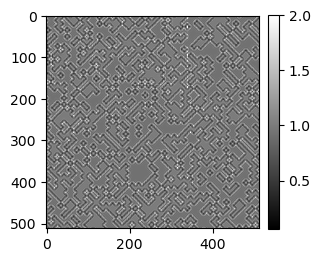

In [6]:
ref0 = cp.array(ref0)
data00 = cp.array(data00)

rdata = data00/ref0
mshow((rdata)[0,0],show,vmax=2)

/tmp/ipykernel_952022/3561898921.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  recMultiPaganin[:,j] = ST(r,shifts_code[:,j])
/tmp/ipykernel_952022/3561898921.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  recMultiPaganinr[:,j] = ST(rr,shifts_code[:,j])


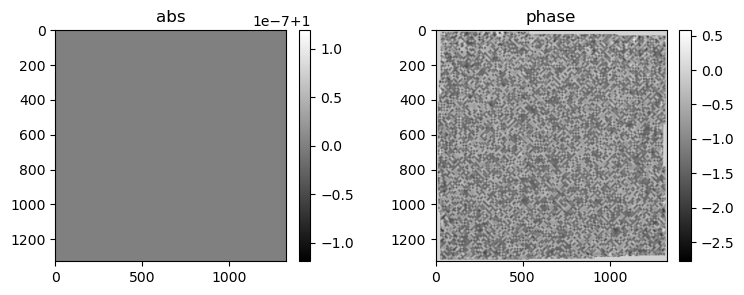

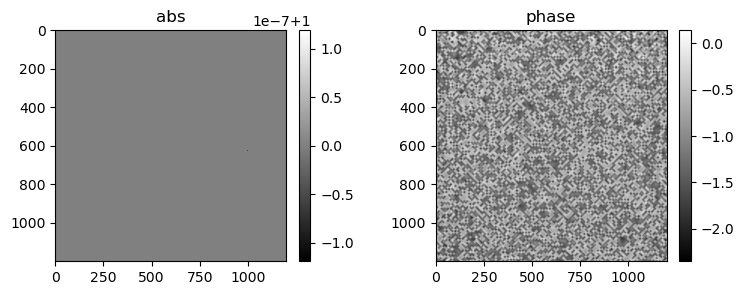

In [7]:
recMultiPaganin = cp.zeros([1,npos,ne,ne],dtype='float32')
recMultiPaganinr = cp.zeros([1,npos,ne,ne],dtype='float32')# to compensate for overlap
for j in range(0,npos):
    r = multiPaganin(rdata[:,j:j+1],
                         distances[j:j+1], wavelength, voxelsize,  24.05, 5e-2)    
    rr = r*0+1 # to compensate for overlap
    r = cp.pad(r,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)),'constant')   
    rr = cp.pad(rr,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)),'constant')   
    recMultiPaganin[:,j] = ST(r,shifts_code[:,j])
    recMultiPaganinr[:,j] = ST(rr,shifts_code[:,j])
    
recMultiPaganin = cp.sum(recMultiPaganin,axis=1)
recMultiPaganinr = cp.sum(recMultiPaganinr,axis=1)

# avoid division by 0
recMultiPaganinr[np.abs(recMultiPaganinr)<5e-2] = 1

# compensate for overlap
recMultiPaganin /= recMultiPaganinr
recMultiPaganin = cp.exp(1j*recMultiPaganin)

mshow_polar(recMultiPaganin[0],show)
mshow_polar(recMultiPaganin[0,pad:-pad,pad:-pad],show)


In [8]:
@gpu_batch
def _fwd_holo0(prb):
    data = cp.zeros([1, npos, n, n], dtype='complex64')
    for j in range(npos):
        # ill shift for each acquisition
        prbr = S(prb)
        # propagate illumination
        data[:, j] = G(prbr, wavelength, voxelsize, distances[0])[:, pad:n+pad, pad:n+pad]
    return data
def fwd_holo0(prb):
    return _fwd_holo0(prb)

@gpu_batch
def _adj_holo0(data):
    prb = cp.zeros([1, n+2*pad, n+2*pad], dtype='complex64')
    for j in range(npos):
        # ill shift for each acquisition
        prbr = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad)))
        # propagate illumination
        prbr = GT(prbr, wavelength, voxelsize, distances[0])
        # ill shift for each acquisition
        prb += prbr
    return prb
def adj_holo0(data):
    return _adj_holo0(data)

# adjoint test
data = cp.array(data00[0, :])
ref = cp.array(ref0)
prb1 = cp.array(ref[0, :1]+1j*ref[0, :1]).astype('complex64')
prb1 = cp.pad(prb1, ((0, 0), (pad, pad), (pad, pad)))
arr2 = fwd_holo0(prb1)
arr3 = adj_holo0(arr2)

print(f'{np.sum(prb1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

(32053148-0.5620951652526855j)==
(32053144-0.0004590433673001826j)


# Estimation with the reference data

0) gammaprb=0.03125, err=1.34719e+05


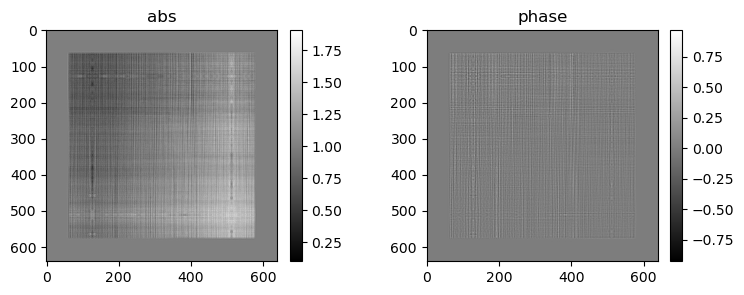

1) gammaprb=0.03125, err=3.72078e+02
2) gammaprb=0.0625, err=1.96315e+01
3) gammaprb=0.03125, err=2.57873e+00
4) gammaprb=0.03125, err=1.33392e-01
5) gammaprb=0.03125, err=1.75225e-02
6) gammaprb=0.03125, err=9.07144e-04
7) gammaprb=0.03125, err=1.19554e-04


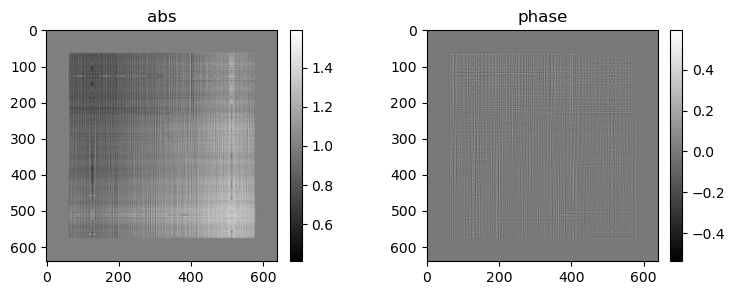

In [9]:
def line_search(minf, gamma, fu, fd):
    """ Line search for the step sizes gamma"""
    while (minf(fu)-minf(fu+gamma*fd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if (gamma <= 1e-12):  # direction not found
        # print('no direction')
        gamma = 0
    return gamma
def cg_holo(ref, init_prb,  pars):
    """Conjugate gradients method for holography"""
    # minimization functional
    def minf(fprb):
        f = np.linalg.norm(np.abs(fprb)-ref)**2
        return f

    ref = np.sqrt(ref)
    prb = init_prb.copy()

    for i in range(pars['niter']):
        fprb0 = fwd_holo0(prb)
        gradprb = adj_holo0(fprb0-ref*np.exp(1j*np.angle(fprb0)))

        if i == 0:
            dprb = -gradprb
        else:
            dprb = dai_yuan(dprb,gradprb,gradprb0)
        gradprb0 = gradprb

        # line search
        fdprb0 = fwd_holo0(dprb)
        gammaprb = line_search(minf, pars['gammaprb'], fprb0, fdprb0)
        prb = prb + gammaprb*dprb

        if i % pars['err_step'] == 0:
            fprb0 = fwd_holo0(prb)
            err = minf(fprb0)
            print(f'{i}) {gammaprb=}, {err=:1.5e}')

        if i % pars['vis_step'] == 0:
            mshow_polar(prb[0],show)

    return prb

rec_prb0 = cp.ones([1, n+2*pad, n+2*pad], dtype='complex64')
ref = cp.array(ref0)
pars = {'niter': 8, 'err_step': 1, 'vis_step': 7, 'gammaprb': 0.5}
rec_prb0 = cg_holo(ref, rec_prb0, pars)

#### Reconstruction with the CG (Carlsson) with Hessians

In [10]:
import time
def line_search(minf, gamma, fu, fd):
    """ Line search for the step sizes gamma"""
    while (minf(fu)-minf(fu+gamma*fd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if (gamma <= 1e-12):  # direction not found
        # print('no direction')
        gamma = 0
    return gamma

# def hessian2(hpsi,hksi,heta,data):
#     Lksi = Lop(hksi)
#     Leta = Lop(heta)
#     Lpsi = Lop(hpsi)        

#     v1 = cp.abs(Lpsi)-data
#     v2 = cp.real(cp.conj(Lksi)*Leta)/cp.abs(Lpsi)            
#     v3 = cp.real(cp.conj(Lpsi)*Lksi) * cp.real(cp.conj(Lpsi)*Leta) / cp.abs(Lpsi)**3    
#     v4 = cp.real(cp.conj(Lpsi)*Lksi)/cp.abs(Lpsi)
#     v5 = cp.real(cp.conj(Lpsi)*Leta)/cp.abs(Lpsi)
#     return 2*(cp.sum(v1 * cp.conj(v2-v3)) + cp.sum(v4*cp.conj(v5)))

def hessian2(hpsi,hksi,heta,data):
    Lksi = Lop(hksi)
    Leta = Lop(heta)
    Lpsi = Lop(hpsi)        

    v1 = cp.abs(Lpsi)-data
    v2 = cp.real(cp.conj(Lksi)*Leta)/cp.abs(Lpsi)            
    v3 = cp.real(cp.conj(Lpsi)*Lksi) * cp.real(cp.conj(Lpsi)*Leta) / cp.abs(Lpsi)**3        
    return 2*(cp.sum(v1 * cp.conj(v2)) + cp.sum(data*cp.conj(v3)))

def cg_holo(data,ref, init_psi,init_prb,  pars):
    """Conjugate gradients method for holography"""
    # minimization functional
    def minf(fpsi):
        f = np.linalg.norm(np.abs(fpsi)-data)**2
        return f

    data = np.sqrt(data)
    ref = np.sqrt(ref)
    psi = init_psi.copy()
    prb = init_prb.copy()

    conv = np.zeros(pars['niter'])
    gammaha = np.zeros(pars['niter'])
    gammah=0
    
   
        
    for i in range(pars['niter']):                                        
        fpsi = Lop(Sop(psi)*prb)
        
        gradx = 2*LTop(fpsi-data*np.exp(1j*np.angle(fpsi)))                                

        gradpsi = STop(gradx*cp.conj(prb))             
        
        gradprb = gradx*cp.conj(Sop(psi))
        gradprb = cp.sum(gradprb,axis=1)        

#        etapsi = -gradpsi
 #       etaprb = -gradprb
        if i==0:
            etapsi = -gradpsi
            etaprb = -gradprb
        else:
            # top
            hpsi = Sop(psi)*prb            
            hksi = Sop(gradpsi)*prb+Sop(psi)*gradprb   
            heta = Sop(etapsi)*prb+Sop(psi)*etaprb                        

            h2u = hessian2(hpsi,hksi,heta,data)
            h2u += cp.real(cp.sum(gradx*cp.conj(Sop(gradpsi)*etaprb)))+ \
                   cp.real(cp.sum(gradx*cp.conj(Sop(etapsi)*gradprb)))
            
            # bottom
            hpsi = Sop(psi)*prb
            heta = Sop(etapsi)*prb+Sop(psi)*etaprb   
            h2b = hessian2(hpsi,heta,heta,data)
            h2b += 2*cp.real(cp.sum(gradx*cp.conj(Sop(etapsi)*etaprb)))

            beta = h2u/h2b
            
            etapsi = -gradpsi + beta*etapsi
            etaprb = -gradprb + beta*etaprb

        #top
        top = -cp.sum(cp.real(gradpsi*cp.conj(etapsi)))-cp.sum(cp.real(gradprb*cp.conj(etaprb)))
        # bottom
        hpsi = Sop(psi)*prb
        heta = Sop(etapsi)*prb+Sop(psi)*etaprb  
        
        h2b = hessian2(hpsi,heta,heta,data)
        h2b += 2*cp.real(cp.sum(gradx*cp.conj(Sop(etapsi)*etaprb)))
        
        gammah = top/h2b 

        npp = 17
        errt = np.zeros(2*npp)
        errt2 = np.zeros(2*npp)
        if i>-1:
            for k in range(0,2*npp):
                psit = psi+(gammah*k/(npp-1))*etapsi
                prbt = prb+(gammah*k/(npp-1))*etaprb
                fpsit = Lop(Sop(psit)*prbt)
                errt[k] = minf(fpsit)    
            t = gammah*(cp.arange(2*npp))/(npp-1)
            errt2 = minf(Lop(Sop(psi)*prb))-top*t+0.5*h2b*t**2
            plt.plot(gammah.get()*np.arange(npp*2)/(npp-1),errt,'.')
            plt.plot(gammah.get()*np.arange(npp*2)/(npp-1),errt2.get(),'.')
            plt.show()


        #     plt.show()
            
        
        # Lpsi = Lop(hpsi)
        # Leta = Lop(heta)
        # gammah = line_search(minf, gammah, Lpsi, Leta)        

        # if gammah==0:
        #     print('warning: use GD')
        #     etapsi = -gradpsi
        #     etaprb = -gradprb
        #     #top
        #     top = -cp.sum(cp.real(gradpsi*cp.conj(etapsi)))-cp.sum(cp.real(gradprb*cp.conj(etaprb)))
        #     # bottom
        #     hpsi = Sop(psi)*prb
        #     heta = Sop(etapsi)*prb+Sop(psi)*etaprb  
            
        #     h2b = hessian2(hpsi,heta,heta,data)
        #     h2b += 2*cp.real(cp.sum(gradx*cp.conj(Sop(etapsi)*etaprb)))
            
        #     gammah = top/h2b 

        #     Lpsi = Lop(hpsi)
        #     Leta = Lop(heta)
        #     gammah = line_search(minf, gammah, Lpsi, Leta)        

        print(f'{h2b=}, {gammah=}')
        psi += gammah*etapsi
        prb += gammah*etaprb

        if i % pars['err_step'] == 0:
            fpsi = Lop(Sop(psi)*prb)
            err = minf(fpsi)
            conv[i] = err
            gammaha[i] = gammah
            print(f'{i}) {gammah=}, {err=:1.5e}')

        if i % pars['vis_step'] == 0:
            mshow_polar(psi[0],show)
            mshow_polar(psi[0,pad:-pad,pad:-pad],show)
            mshow_polar(prb[0],show)

    return psi,prb,conv,gammaha

# fully on gpu
rec_psi = recMultiPaganin.copy()
data = cp.array(data00.copy())
ref = cp.array(ref0.copy())

rec_prb = cp.array(rec_prb0.copy())#cp.abs(rec_prb0).astype('complex64')#*cp.exp().copy()
# rec_psi = cp.array(np.load(f'{path}/data/code_{flg}.npy'))
# nee = rec_psi.shape[1]
# rec_psi = cp.array(rec_psi[:,nee//2-ne//2:nee//2+ne//2,nee//2-ne//2:nee//2+ne//2])
# rec_prb = cp.array(np.load(f'{path}/data/prb_{flg}.npy'))
pars = {'niter': 257, 'err_step': 1, 'vis_step': 16}
rec_psi,rec_prb,conv,gammaha = cg_holo(data,ref,rec_psi,rec_prb, pars)
k = f'cghessians'
np.save(f'data/rec_psi_{k}_{pars['niter']}',rec_psi.get())
np.save(f'data/rec_prb_{k}_{pars['niter']}',rec_prb.get())
np.save(f'data/conv_{k}_{pars['niter']}',conv)
np.save(f'data/gammaha_{k}_{pars['niter']}',gammaha)



TypeError: Sop() takes 1 positional argument but 2 were given

In [ ]:
k = f'gradhessians'
np.save(f'data/rec_psi_{k}_{pars['niter']}',rec_psi.get())
np.save(f'data/rec_prb_{k}_{pars['niter']}',rec_prb.get())
np.save(f'data/conv_{k}_{pars['niter']}',conv)
np.save(f'data/gammaha_{k}_{pars['niter']}',gammaha)

In [ ]:
plt.plot(conv)
plt.yscale('log')
mshow_polar(rec_psi[0],show)
mshow_polar(rec_prb[0],show)

In [ ]:
r = cp.array(np.load(f'{path}/data/code_{flg}.npy'))
nee = r.shape[1]
r = cp.array(r[:,nee//2-ne//2:nee//2+ne//2,nee//2-ne//2:nee//2+ne//2])

In [ ]:
crop = (rec_psi.shape[-1]-(3*n//2+2*pad))//2
plt.imshow(cp.angle(r[0,crop:-crop,crop:-crop]).get(),cmap='gray',vmax=0,vmin=-1)
plt.colorbar()
plt.show()
plt.imshow(cp.angle(rec_psi[0,crop:-crop,crop:-crop]).get(),cmap='gray')#,vmax=0,vmin=-1)
plt.colorbar()
plt.show()

a = np.median(cp.angle(rec_psi[0,crop:-crop,crop:-crop]).get()-cp.angle(r[0,crop:-crop,crop:-crop]).get())
plt.imshow(cp.angle(rec_psi[0,crop:-crop,crop:-crop]).get()-a,cmap='gray')#,vmax=0,vmin=-1)
plt.colorbar()
plt.show()
print(a)
plt.imshow(cp.angle(rec_psi[0,crop:-crop,crop:-crop]).get()-cp.angle(r[0,crop:-crop,crop:-crop]).get()-a,cmap='gray')#,vmax=-0.1,vmin=0.1)
plt.colorbar()
plt.show()

# np.save('data/rec_code',rec_psi.get())


In [ ]:
plt.loglog(conv)
plt.yscale('log')
plt.show()

rec_psis =rec_psi*cp.exp(-1j*a)
plt.imshow(np.angle(rec_psis[0,400:500,400:500]).get(),cmap='gray')
plt.colorbar()
np.save(f'/data2/vnikitin/coded_apertures_new3/data/code_rec_{flg}',rec_psis)

In [ ]:
rr = cp.array(np.load(f'{path}/data/prb_{flg}.npy'))

#mshow_polar(rec_prb[0],show)
plt.imshow(cp.angle(rec_prb[0,100:-100,100:-100]).get(),vmin=-0.3,vmax=0.3,cmap='gray')
plt.show()
plt.imshow(cp.angle(rr[0,100:-100,100:-100]).get(),cmap='gray')
plt.show()

#mshow_polar(rr[0],show)